In [1]:
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

Things to do:
play rate / win rate of items on champions with similar tags
correlate win rate / kda with items (does building defensively help you win games that arent going well?)
cost efficiencies? can i replicate what the generic lol cost breakdown is?

What units are timestamps in? milliseconds

In [2]:
matches_df = pd.read_csv('match_data_2.csv', encoding='utf-8', index_col=0)
matches_df.head()

,championId,highestAchievedSeasonTier,item0_time,item1_time,item2_time,item3_time,item4_time,item5_time,item6_time,masteries,...,timeline.participantId,timeline.role,timeline.xpDiffPerMinDeltas.0-10,timeline.xpDiffPerMinDeltas.10-20,timeline.xpDiffPerMinDeltas.20-30,timeline.xpDiffPerMinDeltas.30-end,timeline.xpPerMinDeltas.0-10,timeline.xpPerMinDeltas.10-20,timeline.xpPerMinDeltas.20-30,timeline.xpPerMinDeltas.30-end
0,103,SILVER,1442408.0,1317001.0,1097684.0,NaN,1955521.0,1859933.0,NaN,NaN,...,1,DUO_CARRY,-19.3,-24.55,-50.25,NaN,332.5,458.8,424.8,NaN
1,267,SILVER,1145366.0,1584846.0,566750.0,1916517.0,1956258.0,1956258.0,NaN,NaN,...,2,DUO_SUPPORT,-19.3,-24.55,-50.25,NaN,306.0,294.8,424.2,NaN
2,24,UNRANKED,704373.0,1326581.0,959447.0,1989154.0,NaN,NaN,NaN,NaN,...,3,NONE,-43.7,-79.20,-2.30,NaN,285.1,459.3,558.5,NaN
3,61,PLATINUM,1170289.0,805550.0,1953211.0,1656055.0,1168408.0,1959599.0,NaN,NaN,...,4,SOLO,13.0,-131.10,60.50,NaN,490.0,434.0,474.4,NaN
4,41,GOLD,1592110.0,644571.0,1142726.0,1834880.0,NaN,NaN,NaN,NaN,...,5,SOLO,-18.2,-190.30,69.40,NaN,411.9,428.6,511.5,NaN


Text(0,0.5,'Purchase Time (ms)')

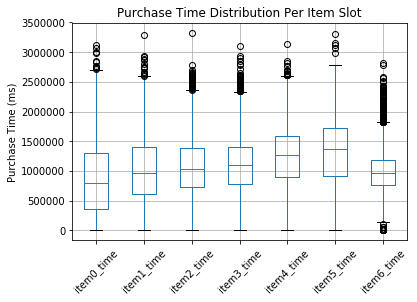

In [3]:
matches_df.boxplot(column=['item0_time', 'item1_time', 'item2_time', 'item3_time',
                           'item4_time', 'item5_time', 'item6_time'], return_type='axes', rot=45)
plt.title('Purchase Time Distribution Per Item Slot')
plt.ylabel('Purchase Time (ms)')

In [4]:
len(matches_df)

9250

In [5]:
matches_df[['championId', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
           'stats.item4', 'stats.item5', 'stats.item6']].head()

,championId,stats.item0,stats.item1,stats.item2,stats.item3,stats.item4,stats.item5,stats.item6
0,103,3020,3152,3285,0,1026,3157,3340
1,267,3117,3107,3092,3024,1029,1029,3340
2,24,1416,3078,3047,3748,0,0,3340
3,61,3020,3285,3157,3135,3165,2139,3340
4,41,3078,3047,3053,3133,0,0,3340


In [6]:
champions_min_df = pd.read_csv('champions_min_8.22.1.csv', encoding='utf-8', index_col=0)
champions_min_df.head(2)

,name,id,key,tags,info.attack,info.defense,info.difficulty,info.magic
champion_name,,,,,,,,
MonkeyKing,Wukong,MonkeyKing,62,"[Fighter, Tank]",8,5,3,2
Jax,Jax,Jax,24,"[Fighter, Assassin]",7,5,5,7


In [7]:
champions_min_df.loc['Jax', 'tags']

u'[Fighter, Assassin]'

In [8]:
champions_min_df['tags'] = [re.findall('[A-Za-z]\w*', champions_min_df.loc[champion, 'tags']) for champion in champions_min_df.index]

In [9]:
champions_min_df.loc['Jax', 'tags']

[u'Fighter', u'Assassin']

In [73]:
champions_min_df.to_csv('champions_min_8.22.1.csv', encoding='utf-8')

In [10]:
len(champions_min_df)

141

In [11]:
champions_min_df[champions_min_df['key'] == 41]

,name,id,key,tags,info.attack,info.defense,info.difficulty,info.magic
champion_name,,,,,,,,
Gangplank,Gangplank,Gangplank,41,[Fighter],7,6,9,4


In [12]:
items_df = pd.read_csv('items.8.22.1.csv', encoding='utf-8', index_col=0)
items_df.head(2)

,name,description,consumed,base_gold,depth,sr,effect1amount,effect2amount,effect3amount,effect4amount,...,flat_hp_pool_mod,flat_hp_regen_mod,flat_magic_dmg_mod,flat_ms_mod,flat_phys_dmg_mod,flat_spellblock_mod,flat_pct_atk_speed_mod,pct_lifesteal_mod,pct_movespeed_mod,tags
item_id,,,,,,,,,,,,,,,,,,,,,
1001,Boots of Speed,<groupLimit>Limited to 1 pair of boots.</group...,0,300,0.0,True,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,[Boots]
1004,Faerie Charm,<stats><mana>+25% Base Mana Regen </mana></stats>,0,125,0.0,True,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[ManaRegen]


In [13]:
items_df.columns

Index([u'name', u'description', u'consumed', u'base_gold', u'depth', u'sr',
       u'effect1amount', u'effect2amount', u'effect3amount', u'effect4amount',
       u'effect5amount', u'effect6amount', u'effect7amount', u'effect8amount',
       u'from', u'into', u'gold_purchasable', u'total_gold', u'req_champion',
       u'special_recipe', u'stacks', u'flat_armor_mod',
       u'flat_crit_chance_mod', u'flat_hp_pool_mod', u'flat_hp_regen_mod',
       u'flat_magic_dmg_mod', u'flat_ms_mod', u'flat_phys_dmg_mod',
       u'flat_spellblock_mod', u'flat_pct_atk_speed_mod', u'pct_lifesteal_mod',
       u'pct_movespeed_mod', u'tags'],
      dtype='object')

In [14]:
len(items_df[items_df['gold_purchasable'] == True])*6/9250.0

0.13037837837837837

In [15]:
6.0/len(items_df[items_df['gold_purchasable'] == True])

0.029850746268656716

Some of the columns are still unicoded. Use eval() to get around that

In [16]:
final_item = []
for into_list in items_df['into']:
    if (type(eval(into_list)) == int) and (eval(into_list) == 0):
        final_item.append(True)
    else:
        final_item.append(False)

In [17]:
items_df['full_item'] = final_item

Need to convert the tags column into a list of strings

In [18]:
re.findall('[A-Za-z]\w*', items_df.loc[3800, 'tags'])

[u'Health',
 u'HealthRegen',
 u'Armor',
 u'Mana',
 u'Active',
 u'CooldownReduction',
 u'Slow',
 u'NonbootsMovement']

In [19]:
items_df['tags'] = [re.findall('[A-Za-z]\w*', items_df.loc[item_id, 'tags']) for item_id in items_df.index]

In [20]:
items_df[(items_df['full_item'] == True) & (items_df['total_gold'] != 0)][['name', 'base_gold', 'total_gold', 'tags']].tail()

,name,base_gold,total_gold,tags
item_id,,,,
3800,Righteous Glory,1100,2650,"[Health, HealthRegen, Armor, Mana, Active, Coo..."
3812,Death's Dance,625,3500,"[Damage, LifeSteal, CooldownReduction]"
3814,Edge of Night,625,3000,"[Health, Damage, Active, ArmorPenetration]"
3905,Twin Shadows,650,2400,"[SpellDamage, Active, CooldownReduction, Slow,..."
3907,Spellbinder,800,2900,"[SpellDamage, Active, NonbootsMovement]"


In [74]:
items_df.to_csv('items.8.22.1.csv', encoding='utf-8')

# Build an item-indexed dataframe

In [21]:
match_items = pd.DataFrame(matches_df[['stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                          'stats.item4', 'stats.item5', 'stats.item6']].stack().reset_index(drop=True),
                          columns=['item_id'])

In [22]:
item_occ = pd.DataFrame(match_items.groupby('item_id').size(),
                        columns=['count'])

In [23]:
item_occ['pick_rate'] = item_occ['count']/len(matches_df)
item_occ.head()

,count,pick_rate
item_id,,
0,5659,0.611784
1001,459,0.049622
1004,78,0.008432
1006,46,0.004973
1011,269,0.029081


Needed for champion spread

In [24]:
match_min_df = pd.DataFrame(matches_df[['championId', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                        'stats.item4', 'stats.item5', 'stats.item6']])

In [25]:
item_stack_sub_dfs = []
for col_name in match_min_df.columns[1:]:
    sub_df = match_min_df[['championId', col_name]]
    sub_df.columns = ['championId', 'item_id']
    item_stack_sub_dfs.append(sub_df)

In [26]:
item_stack_df = pd.concat(item_stack_sub_dfs)

In [27]:
len(item_stack_df)

64750

In [28]:
len(item_stack_df.drop_duplicates())

7327

In [29]:
champion_spread = item_stack_df.drop_duplicates().groupby('item_id').size()

In [30]:
item_occ['spread'] = champion_spread

In [31]:
item_occ.head()

,count,pick_rate,spread
item_id,,,
0,5659,0.611784,141
1001,459,0.049622,113
1004,78,0.008432,23
1006,46,0.004973,27
1011,269,0.029081,70


Needed for win rate calculation

In [32]:
items_and_wins_df = matches_df[['stats.win', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                        'stats.item4', 'stats.item5', 'stats.item6']]
items_and_wins_df.head(10)

,stats.win,stats.item0,stats.item1,stats.item2,stats.item3,stats.item4,stats.item5,stats.item6
0,False,3020,3152,3285,0,1026,3157,3340
1,False,3117,3107,3092,3024,1029,1029,3340
2,False,1416,3078,3047,3748,0,0,3340
3,False,3020,3285,3157,3135,3165,2139,3340
4,False,3078,3047,3053,3133,0,0,3340
5,True,2033,3147,3047,3071,3036,3155,3340
6,True,3155,3095,3031,3006,3094,3072,3340
7,True,3020,3285,3157,1058,3116,0,3340
8,True,3401,3190,3107,3117,1029,1029,3364
9,True,3156,1400,3053,3047,3071,1029,3340


In [33]:
item_win_sub_dfs = []
for col_name in items_and_wins_df.columns[1:]:
    sub_df = items_and_wins_df[['stats.win', col_name]]
    sub_df.columns = ['stats.win', 'item_id']
    item_win_sub_dfs.append(sub_df)

DataFrame of # of wins with each item

In [34]:
item_win_df = pd.concat(item_win_sub_dfs)
item_win_df.columns = ['wins', 'item_id']
item_occ['wins'] = item_win_df.groupby('item_id').sum()['wins']
item_occ.head()

,count,pick_rate,spread,wins
item_id,,,,
0,5659,0.611784,141,2400.0
1001,459,0.049622,113,159.0
1004,78,0.008432,23,28.0
1006,46,0.004973,27,18.0
1011,269,0.029081,70,129.0


3400: Your Cut. Not common to see in the end inventory. 3520: Ghost Poro. Not purchasable. 3379: Infernal Mask. Ornn special item. Uncommon.

3383: Circlet of the Iron Solari. Ornn special item. 

In [35]:
item_occ['win_rate'] = item_occ['wins']/item_occ['count']
item_occ.head()

,count,pick_rate,spread,wins,win_rate
item_id,,,,,
0,5659,0.611784,141,2400.0,0.424103
1001,459,0.049622,113,159.0,0.346405
1004,78,0.008432,23,28.0,0.358974
1006,46,0.004973,27,18.0,0.391304
1011,269,0.029081,70,129.0,0.479554


In [75]:
item_occ.to_csv('item_occurrences_8.22.1.csv', encoding='utf-8')

In [36]:
item_occ = item_occ.join(items_df[['name', 'full_item', 'total_gold', 'tags']])
item_occ.tail()

,count,pick_rate,spread,wins,win_rate,name,full_item,total_gold,tags
item_id,,,,,,,,,
3812,177,0.019135,36,106.0,0.598870,Death's Dance,True,3500.0,"[Damage, LifeSteal, CooldownReduction]"
3814,48,0.005189,16,26.0,0.541667,Edge of Night,True,3000.0,"[Health, Damage, Active, ArmorPenetration]"
3905,96,0.010378,29,46.0,0.479167,Twin Shadows,True,2400.0,"[SpellDamage, Active, CooldownReduction, Slow,..."
3907,69,0.007459,28,43.0,0.623188,Spellbinder,True,2900.0,"[SpellDamage, Active, NonbootsMovement]"
3916,159,0.017189,48,82.0,0.515723,Oblivion Orb,False,1500.0,"[Health, MagicPenetration, SpellDamage]"


In [37]:
item_occ.sort_values('count', ascending=False).head(15)

,count,pick_rate,spread,wins,win_rate,name,full_item,total_gold,tags
item_id,,,,,,,,,
0,5659,0.611784,141,2400.0,0.424103,NaN,NaN,NaN,NaN
3340,5270,0.569730,141,2573.0,0.488235,Warding Totem (Trinket),True,0.0,"[Active, Jungle, Lane, Trinket, Vision]"
3364,2444,0.264216,131,1276.0,0.522095,Oracle Lens,True,0.0,"[Active, Trinket, Vision]"
3047,1957,0.211568,127,959.0,0.490036,Ninja Tabi,True,1100.0,"[Armor, Boots]"
3020,1621,0.175243,68,884.0,0.545342,Sorcerer's Shoes,True,1100.0,"[Boots, MagicPenetration]"
3006,1506,0.162811,39,786.0,0.521912,Berserker's Greaves,True,1100.0,"[AttackSpeed, Boots]"
3363,1492,0.161297,120,759.0,0.508713,Farsight Alteration,True,0.0,"[Active, Trinket, Vision]"
3111,1452,0.156973,129,714.0,0.491736,Mercury's Treads,True,1100.0,"[Boots, SpellBlock, Tenacity]"
2031,1227,0.132649,135,555.0,0.452323,Refillable Potion,False,150.0,"[HealthRegen, Consumable, Active, Lane, Jungle]"


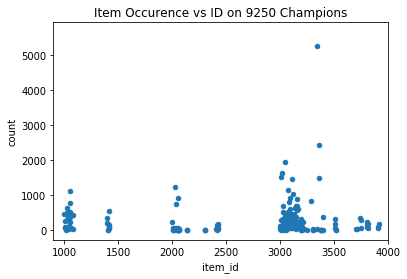

In [38]:
item_occ.reset_index().plot(x='item_id' , y='count', kind='scatter', title='Item Occurence vs ID on 9250 Champions',
              xlim=[900, 4000])

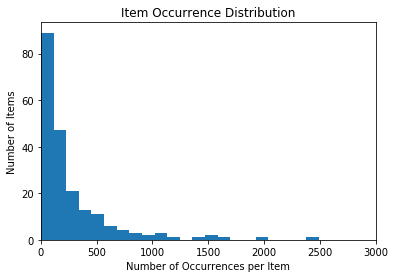

In [39]:
item_occ['count'].plot.hist(title='Item Occurrence Distribution',
                           xlim=[0,3000], bins=50)
plt.xlabel('Number of Occurrences per Item')
plt.ylabel('Number of Items')
plt.savefig('item_occurrence_dist.png')

Unsurprisingly, the two most common items are warding trinkets (only 3 options for item slot 6) (the third warding trinket is rank 6)

Ranks 3, 4, 5, and 7 are all Boots. This is also unsurprising, because it is traditional for each character (except Cassiopeia) to build one boot item (good cost effectiveness, see more on that later)

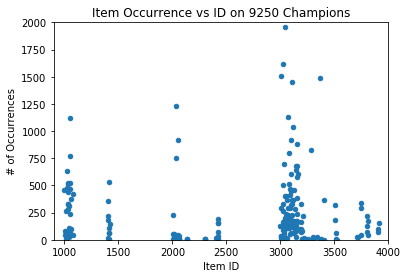

In [40]:
item_occ.reset_index().plot(x='item_id' , y='count', kind='scatter',
                            title='Item Occurrence vs ID on 9250 Champions',
                            xlim=[900, 4000], ylim=[0, 2000])
plt.ylabel('# of Occurrences')
plt.xlabel('Item ID')
plt.savefig('item_occurrence_vs_id.png')

To get the pick rate, divide the # of occurrences by the length of the dataframe matches_df. Each item is usually built 0 or 1 times per champion per game. The dotted line is the expected pick rate. The chance of picking a random item is 1/(# items), so the chance of randomly picking 6 is roughly 6 times that (or exactly if you can pick items multiple times). Since not all players can purchase 6 items before games end, this number should be higher. Since players generally try to build items into full items (into=[]), this number should be higher.

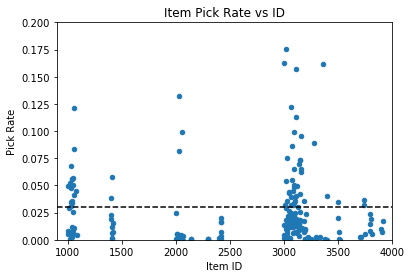

In [41]:
item_occ.reset_index().plot(x='item_id' , y='pick_rate', kind='scatter',
                            title='Item Pick Rate vs ID', xlim=[900, 4000], ylim=[0, 0.2])
plt.plot(np.linspace(900, 4000, num=50),
         np.full(50, 6.0/len(items_df[items_df['gold_purchasable'] == True])),
         'k--')
plt.ylabel('Pick Rate')
plt.xlabel('Item ID')
plt.savefig('item_pick_rate_vs_id.png')

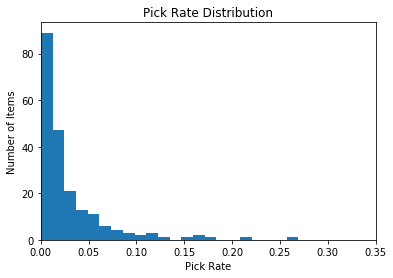

In [42]:
item_occ['pick_rate'].plot.hist(title='Pick Rate Distribution', xlim=[0,0.35], bins=50)
plt.xlabel('Pick Rate')
plt.ylabel('Number of Items')
plt.savefig('item_pick_rate_dist.png')

Champion Spread vs Item

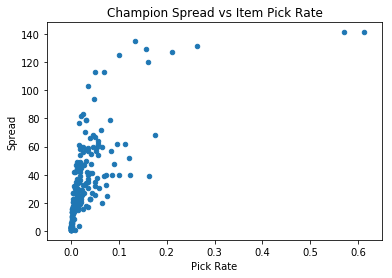

In [43]:
item_occ.reset_index().plot(x='pick_rate', y='spread', kind='scatter',
                            xlim=[-0.05, 0.65], title='Champion Spread vs Item Pick Rate')
plt.xlabel('Pick Rate')
plt.ylabel('Spread')
plt.savefig('champion_spread_vs_pick_rate.png')

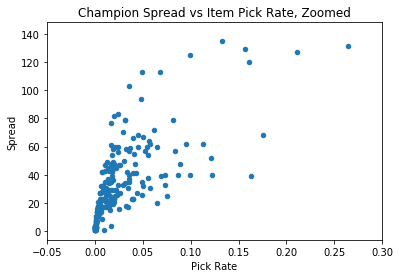

In [44]:
item_occ.reset_index().plot(x='pick_rate', y='spread', kind='scatter',
                            xlim=[-0.05, 0.3], title='Champion Spread vs Item Pick Rate, Zoomed')
plt.xlabel('Pick Rate')
plt.ylabel('Spread')
plt.savefig('champion_spread_vs_pick_rate_zoomed.png')

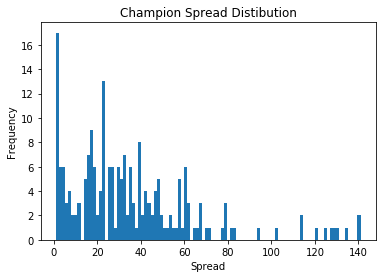

In [45]:
item_occ['spread'].plot.hist(title='Champion Spread Distibution', bins=100)
plt.xlabel('Spread')
plt.savefig('champion_spread_dist.png')

Item Win Rate: # of games with item & win / # of games with item. The true average of actual items should be slightly higher than 50%. The average win rate of a missing item (0) is about 42%, because players without full builds tend to lose vs players with full builds.

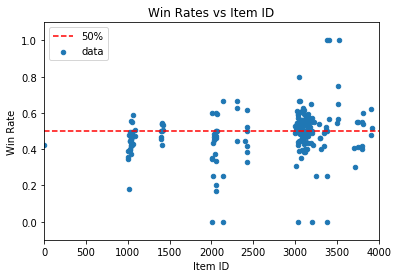

In [46]:
centerline_x = np.linspace(0, 4000, num=50)
centerline_y = np.full(50, 0.5)

item_occ.reset_index().plot(x='item_id', y='win_rate', kind='scatter', xlim=[0, 4000], ylim=[-0.1,1.1], label='data', title='Win Rates vs Item ID')
plt.plot(centerline_x, centerline_y, 'r--', label='50%')
plt.legend(loc=2)
plt.ylabel('Win Rate')
plt.xlabel('Item ID')
plt.savefig('win_rate_vs_item_id.png')

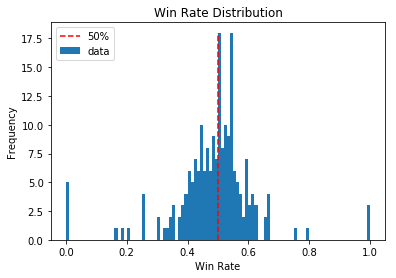

In [47]:
item_occ['win_rate'].plot.hist(title='Win Rate Distribution', bins=100,
                              label='data')
fifty_pct_line_y = np.linspace(0, 18, num = 50)
fifty_pct_line_x = np.full(50, 0.5)
plt.plot(fifty_pct_line_x, fifty_pct_line_y, 'r--', label='50%')
plt.legend(loc=2)
plt.xlabel('Win Rate')
plt.savefig('win_rate_dist.png')

Remove items with fewer than 5 games in the dataframe. This gets rid of all the values at 0 and 1.0

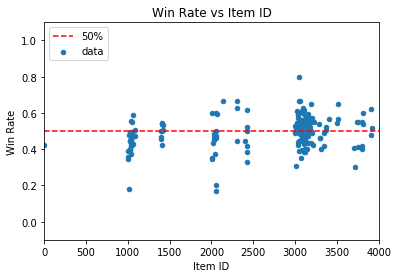

In [48]:
item_occ[item_occ['count'] >= 5].reset_index().plot(x='item_id', y='win_rate', kind='scatter',
                                                  xlim=[0, 4000], ylim=[-0.1,1.1], label='data', title='Win Rate vs Item ID')
plt.plot(centerline_x, centerline_y, 'r--', label='50%')
plt.legend(loc=2)
plt.ylabel('Win Rate')
plt.xlabel('Item ID')
plt.savefig('win_rate_vs_item_id_clipped.png')

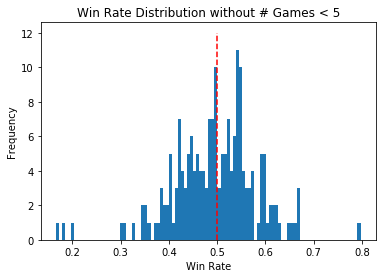

In [49]:
item_occ[item_occ['count'] >= 5]['win_rate'].plot.hist(title='Win Rate Distribution without # Games < 5',
                                                      bins=100, label='data')
fifty_pct_line_y = np.linspace(0, 12, num = 50)
fifty_pct_line_x = np.full(50, 0.5)
plt.plot(fifty_pct_line_x, fifty_pct_line_y, 'r--', label='50%')
plt.xlabel('Win Rate')
plt.savefig('win_rate_dist_clipped.png')

Pick rate vs win rate

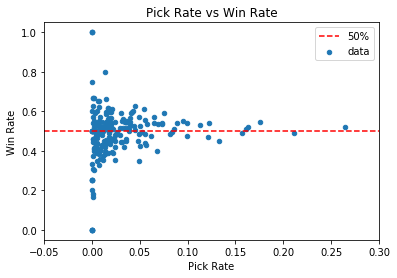

In [50]:
item_occ.plot(x='pick_rate', y='win_rate', kind='scatter', title='Pick Rate vs Win Rate',
             xlim=[-0.05, 0.3], ylim=[-0.05, 1.05], label='data')
plt.plot(np.linspace(-0.05, 0.30, num = 50), np.full(50, 0.5), 'r--', label='50%')
plt.xlabel('Pick Rate')
plt.ylabel('Win Rate')
plt.legend(loc='best')
plt.savefig('pick_rate_vs_win_rate.png')

This seems to mostly show win rate converging towards 50% as pick rate increases.

Distributions of item costs, correlations with item costs

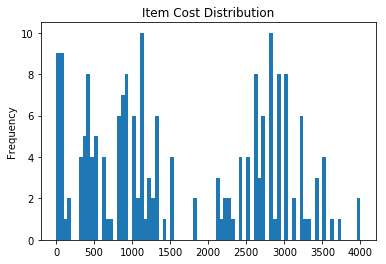

In [51]:
item_occ['total_gold'].plot.hist(title='Item Cost Distribution', bins=80)

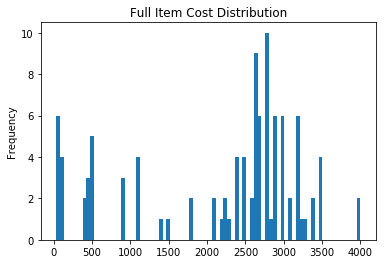

In [52]:
item_occ[(item_occ['full_item'] == True) &
         (item_occ['total_gold'] != 0)]['total_gold'].plot.hist(title='Full Item Cost Distribution', bins=80)

This graph has a small problem in that the items that can be upgraded with Ornn's passive are now not registered as 'full' items, and don't show up here.

Might be cool to show the following plots with 1 tag colored differently to highlight differences.

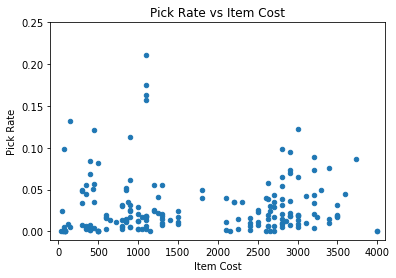

In [53]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='pick_rate',
                                            title='Pick Rate vs Item Cost', kind='scatter',
                                            xlim=[-100,4100], ylim=[-0.01,0.25])
plt.xlabel('Item Cost')
plt.ylabel('Pick Rate')
plt.savefig('pick_rate_vs_item_cost.png')

The three highest points are the most popular boots. Aside from that, I'm not sure if this is giving me any insights without some information on tags.

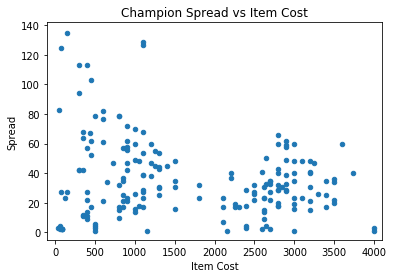

In [54]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='spread',
                                            title='Champion Spread vs Item Cost', kind='scatter',
                                            xlim=[-100, 4100], ylim=[-5, 142])
plt.xlabel('Item Cost')
plt.ylabel('Spread')
plt.savefig('champion_spread_vs_item_cost.png')

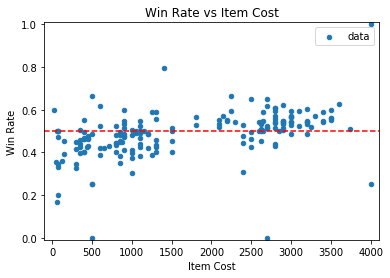

In [55]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='win_rate',
                                            title='Win Rate vs Item Cost', kind='scatter',
                                            xlim=[-100,4100], ylim=[-0.01,1.01], label='data')
plt.plot(np.linspace(-100, 4100, num = 50),
         np.full(50, 0.5), 'r--', label='50%')
plt.ylabel('Win Rate')
plt.xlabel('Item Cost')
plt.savefig('win_rate_vs_item_cost.png')

This plot shows that there is a slightly higher win rate for the more expensive group of items (full items). This is expected

Can I tell how win rate changes if an item is finished?

Start looking at item tags and break up the previous plots into those groupings

Make the set of tags

In [56]:
tag_list = [tag for tags in item_occ['tags'] if type(tags) != float for tag in tags]
tag_list = set(tag_list)
tag_list.remove('Bilgewater')
tag_list

{u'Active',
 u'Armor',
 u'ArmorPenetration',
 u'AttackSpeed',
 u'Aura',
 u'Boots',
 u'Consumable',
 u'CooldownReduction',
 u'CriticalStrike',
 u'Damage',
 u'GoldPer',
 u'Health',
 u'HealthRegen',
 u'Jungle',
 u'Lane',
 u'LifeSteal',
 u'MagicPenetration',
 u'Mana',
 u'ManaRegen',
 u'NonbootsMovement',
 u'OnHit',
 u'Slow',
 u'SpellBlock',
 u'SpellDamage',
 u'SpellVamp',
 u'Stealth',
 u'Tenacity',
 u'Trinket',
 u'Vision'}

Function to get the tables of a given tag

In [57]:
def get_items_of_tag(df, tag):
    if (tag not in tag_list):
        raise ValueError('Could not find ' + tag + ' in the tag list')
    given_tag_list = []
    for tags in df['tags']:
        found_tag = True if type(tags) != float and tag in tags else False
        given_tag_list.append(found_tag)
    return df[given_tag_list]

In [58]:
test_fn_df = get_items_of_tag(item_occ, 'Damage').sort_values('win_rate', ascending=False)
test_fn_df

,count,pick_rate,spread,wins,win_rate,name,full_item,total_gold,tags
item_id,,,,,,,,,
2140,6,0.000649,6,4.0,0.666667,Elixir of Wrath,True,500.0,"[Consumable, Damage, LifeSteal, SpellVamp]"
3026,503,0.054378,60,307.0,0.610338,Guardian Angel,True,2800.0,"[Armor, Damage]"
3053,399,0.043135,41,241.0,0.604010,Sterak's Gage,True,3200.0,"[Health, Damage]"
3812,177,0.019135,36,106.0,0.598870,Death's Dance,True,3500.0,"[Damage, LifeSteal, CooldownReduction]"
3036,136,0.014703,29,81.0,0.595588,Lord Dominik's Regards,True,2800.0,"[Damage, ArmorPenetration]"
3031,697,0.075351,25,412.0,0.591105,Infinity Edge,False,3400.0,"[CriticalStrike, Damage]"
3124,456,0.049297,26,261.0,0.572368,Guinsoo's Rageblade,True,3300.0,"[Damage, AttackSpeed, SpellDamage, OnHit]"
3033,77,0.008324,32,44.0,0.571429,Mortal Reminder,True,2800.0,"[ArmorPenetration, Damage]"
3508,185,0.020000,23,105.0,0.567568,Essence Reaver,True,3000.0,"[Damage, AttackSpeed, Mana, ManaRegen, Cooldow..."


Most of the complete items have win rates higher than 50%. This makes sense, because players with incomplete items at the end of the game are more likely to be behind, and thus lose.

Making stats off of this might be inaccurate, since a lot of players will build multiple items of the same tag. Need weight

In [59]:
tag_based_stats_df = pd.DataFrame()
for idx, tag in enumerate(tag_list):
    tag_df = get_items_of_tag(item_occ, tag)
    tag_based_stats_df.loc[idx, 'tag'] = tag
    tag_based_stats_df.loc[idx, 'pick_count'] = tag_df['count'].sum()
    tag_based_stats_df.loc[idx, 'avg_pick_rate'] = (tag_df['pick_rate'] * tag_df['count']).sum() / tag_df['count'].sum()
    #tag_based_stats_df.loc[idx, 'std_pick_rate'] = tag_df['pick_rate'].std()
    tag_based_stats_df.loc[idx, 'avg_win_rate'] = (tag_df['win_rate'] * tag_df['count']).sum() / tag_df['count'].sum()
    #tag_based_stats_df.loc[idx, 'std_win_rate'] = tag_df['win_rate'].std()
    tag_based_stats_df.loc[idx, 'avg_champ_spread'] = tag_df['spread'].mean()
    tag_based_stats_df.loc[idx, 'avg_item_cost'] = tag_df['total_gold'].mean()

In [60]:
tag_based_stats_df.sort_values('avg_win_rate', ascending=False)

,tag,pick_count,avg_pick_rate,avg_win_rate,avg_champ_spread,avg_item_cost
14,Aura,909.0,0.022341,0.558856,23.714286,2200.000000
18,MagicPenetration,2792.0,0.120411,0.553367,43.666667,2541.666667
19,CriticalStrike,3375.0,0.064845,0.550519,25.750000,2375.000000
25,ArmorPenetration,2981.0,0.080383,0.536397,25.400000,2430.000000
23,SpellDamage,10861.0,0.049574,0.533653,34.071429,1974.166667
20,OnHit,8317.0,0.070238,0.532644,25.307692,2441.653846
13,SpellVamp,308.0,0.015910,0.532468,18.000000,1807.500000
21,Mana,4715.0,0.046319,0.530223,27.440000,2205.320000
27,NonbootsMovement,8497.0,0.062964,0.529363,25.806452,2223.000000
1,AttackSpeed,6997.0,0.081729,0.525225,27.647059,2243.117647


In [76]:
tag_based_stats_df.to_csv('tag_based_stats_8.22.1.csv', encoding='utf-8')

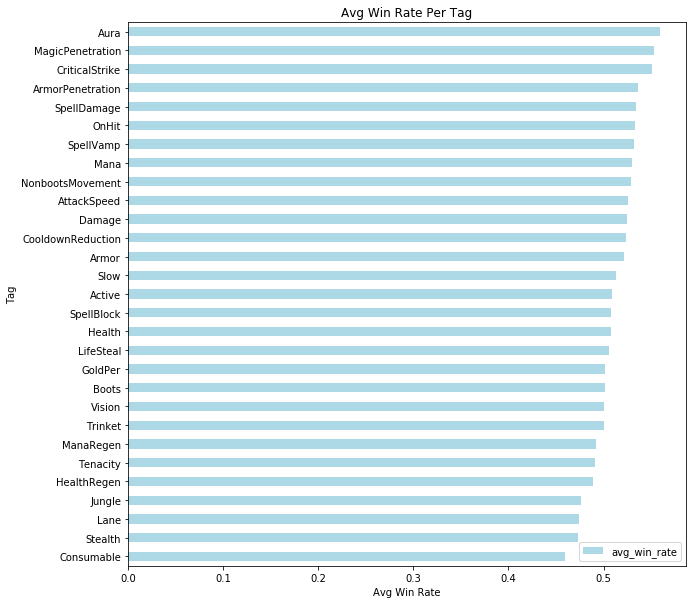

In [61]:
tag_based_stats_df.sort_values('avg_win_rate').plot(x='tag', y='avg_win_rate', kind='barh', figsize=(10,10),
                        color='lightblue', title='Avg Win Rate Per Tag')
plt.ylabel('Tag')
plt.xlabel('Avg Win Rate')
plt.savefig('avg_win_rate_per_tag.png')

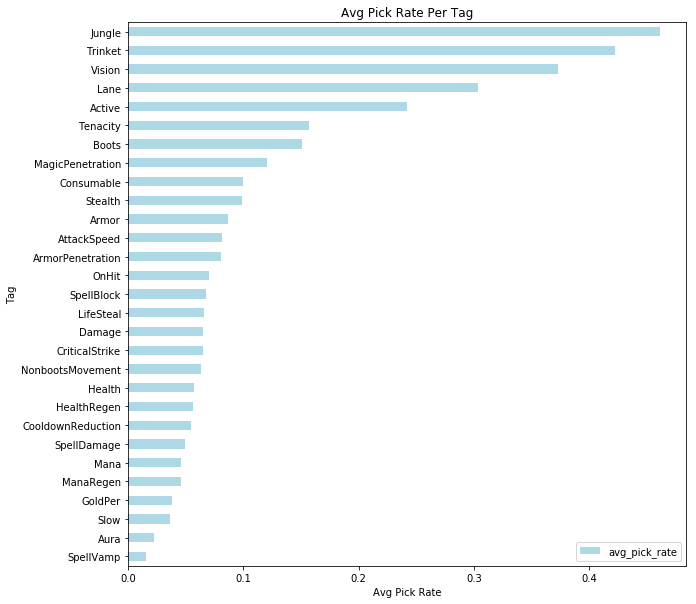

In [62]:
tag_based_stats_df.sort_values('avg_pick_rate').plot(x='tag', y='avg_pick_rate', kind='barh', figsize=(10,10),
                        color='lightblue', title='Avg Pick Rate Per Tag')
plt.ylabel('Tag')
plt.xlabel('Avg Pick Rate')
plt.savefig('avg_pick_rate_per_tag.png')

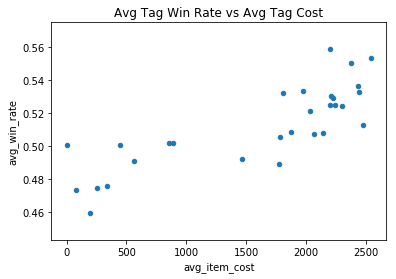

In [63]:
tag_based_stats_df.plot(y='avg_win_rate', x='avg_item_cost', kind='scatter', title='Avg Tag Win Rate vs Avg Tag Cost')

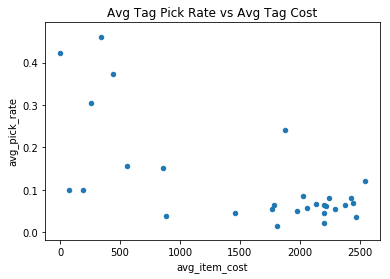

In [64]:
tag_based_stats_df.plot(y='avg_pick_rate', x='avg_item_cost', kind='scatter', title='Avg Tag Pick Rate vs Avg Tag Cost')

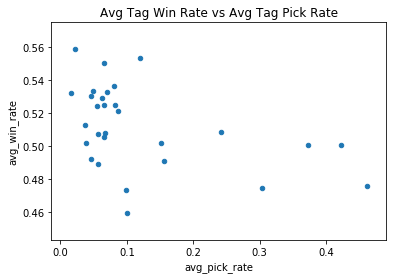

In [65]:
tag_based_stats_df.plot(y='avg_win_rate', x='avg_pick_rate', kind='scatter', title='Avg Tag Win Rate vs Avg Tag Pick Rate')

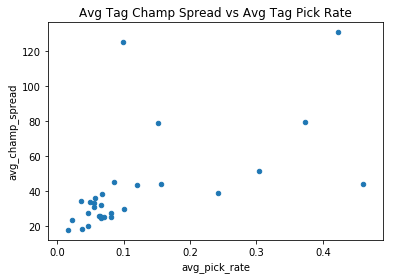

In [66]:
tag_based_stats_df.plot(y='avg_champ_spread', x='avg_pick_rate', kind='scatter',
                        title='Avg Tag Champ Spread vs Avg Tag Pick Rate')

# Build a timing dataframe

Make a dataframe that has individual game data, but one item with its purchase time per row. With NaN values (in purchase_time) there are 64750 rows. After dropna(), there are 52890. Should I put it what item # it is? Does this change if you swap inventory slots, or is it time-ordered?

In [67]:
item_cols = ['stats.item0', 'stats.item1', 'stats.item2', 'stats.item3', 'stats.item4', 'stats.item5', 'stats.item6']
timing_cols = ['item0_time', 'item1_time', 'item2_time', 'item3_time', 'item4_time', 'item5_time', 'item6_time']

timing_df_list = []
for (item, time) in zip(item_cols, timing_cols):
    sub_df = matches_df[[item, time, 'stats.win']]
    sub_df.columns = ['item_id', 'purchase_time', 'win']
    timing_df_list.append(sub_df)

timing_df = pd.concat(timing_df_list).dropna().reset_index(drop=True)
timing_df = timing_df.set_index('item_id').join(items_df[['name', 'full_item', 'total_gold', 'tags']]).reset_index()
timing_df.sort_values('purchase_time').head()

,item_id,purchase_time,win,name,full_item,total_gold,tags
7357,1056,1793.0,False,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
7992,1056,2001.0,True,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
8067,1056,2125.0,True,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
7894,1056,2185.0,False,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"
7740,1056,2241.0,True,Doran's Ring,True,400.0,"[Health, Lane, ManaRegen, SpellDamage]"


In [77]:
timing_df.to_csv('item_timing_8.22.1.csv', encoding='utf-8')

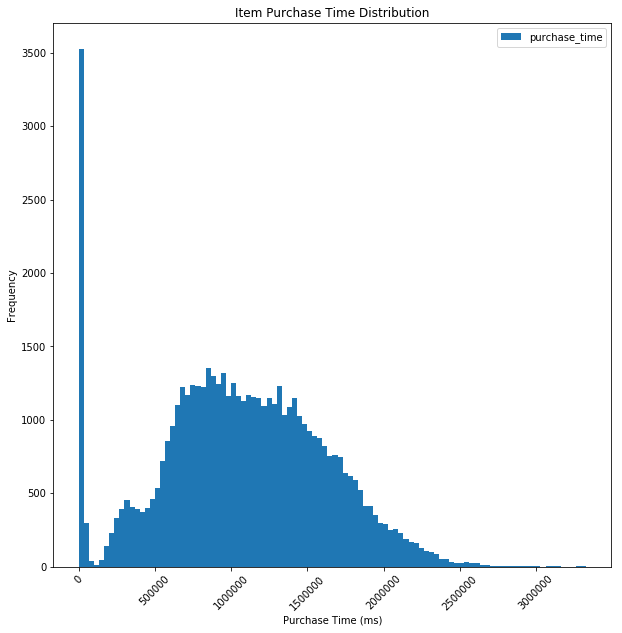

In [68]:
timing_df.plot(y='purchase_time', kind='hist', rot=45, figsize=(10,10), bins=100,
              title='Item Purchase Time Distribution')
plt.xlabel('Purchase Time (ms)')
plt.savefig('item_purchase_time_dist.png')

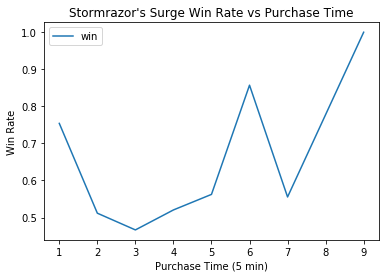

In [69]:
timing_df[timing_df['name'] == 'Stormrazor'].groupby(timing_df['purchase_time'] // 300000).mean().plot(y='win')
plt.title('Stormrazor\'s Surge Win Rate vs Purchase Time')
plt.xlabel('Purchase Time (5 min)')
plt.ylabel('Win Rate')
plt.savefig('stormrazor_win_rate_vs_purchase_time.png')

purchase time ranges from 1793.0 to 3,328,290.0

In [70]:
tag_labeled_df_list = []

for tag in tag_list:
    timing_tags_df = get_items_of_tag(timing_df, tag)
    timing_tags_df['tag'] = tag
    tag_labeled_df_list.append(timing_tags_df)
#timing_tags_df[timing_tags_df['win'] == True].plot(y='purchase_time', kind='hist', bins=100, ylim=[0,1000])
tag_labeled_df = pd.concat(tag_labeled_df_list)
tag_labeled_df.head()

/Users/Stitchclone3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,item_id,purchase_time,win,name,full_item,total_gold,tags,tag
14038,2065,1015088.0,True,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14039,2065,1745323.0,True,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14040,2065,1220367.0,False,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14041,2065,1604704.0,True,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction
14042,2065,1610208.0,False,Shurelya's Reverie,True,2250.0,"[Health, SpellDamage, ManaRegen, Active, Coold...",CooldownReduction


In [71]:
#timing_tags_df.boxplot(column='purchase_time', by='win')

Plot win rate every 5 min? distinguish specific items?

Text(0,0.5,'Win Rate')

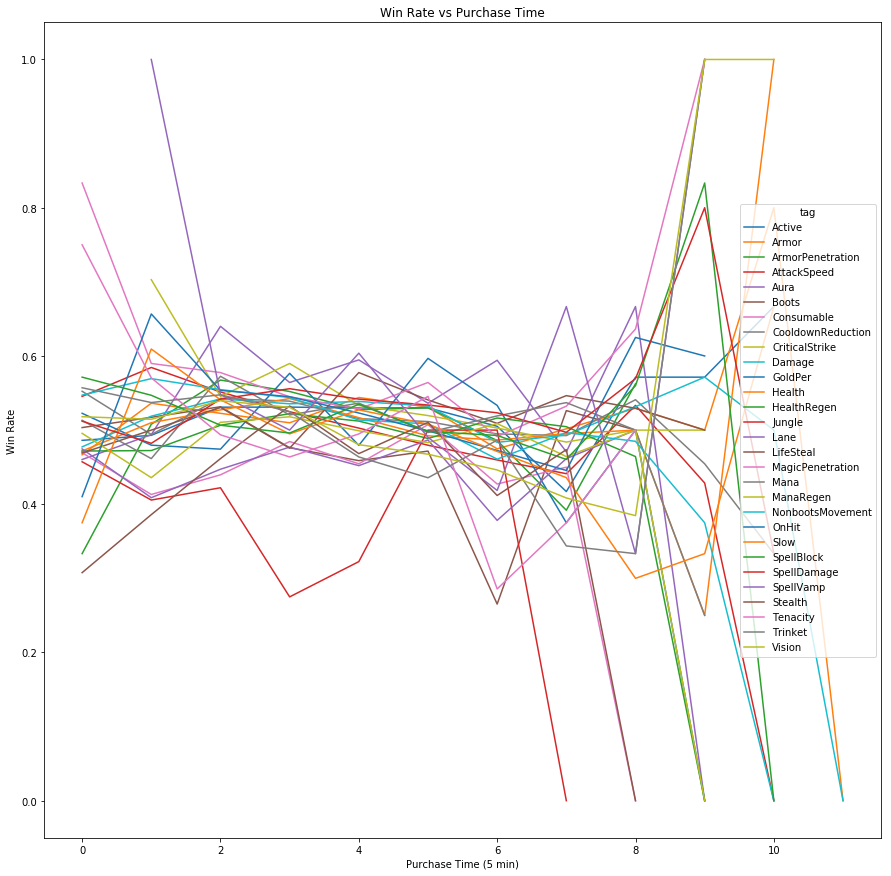

In [72]:
tag_based_time_win_rates = tag_labeled_df.groupby([tag_labeled_df['purchase_time'] // 300000, 'tag']).mean().unstack('tag')[['win']]
tag_based_time_win_rates.plot(y='win', title='Win Rate vs Purchase Time', figsize=(15,15))
plt.xlabel('Purchase Time (5 min)')
plt.ylabel('Win Rate')

This is gross. I'll do better in a bit.